# Model 1: Linear Regression with Weather Variables

The first model is a Bayesian linear regression model that predicts the number of public transport passengers based on weather conditions and temporal features.


A Bayesian linear regression model was chosen for this analysis for several key reasons:

1. **Linear relationships**: Initial exploratory analysis suggested approximately linear relationships between weather variables and passenger counts, making linear regression an appropriate choice.

2. **Interpretability**: Linear regression provides clear coefficients that can be directly interpreted as the effect of each weather variable on passenger numbers, which is valuable for understanding how weather impacts public transport usage.

3. **Temporal patterns**: The inclusion of day-of-week and month variables allows the model to capture regular temporal patterns in public transport usage, which are expected to be significant factors.

4. **Uncertainty quantification**: The Bayesian approach provides full posterior distributions rather than point estimates, allowing for better uncertainty quantification in predictions, which is important for transportation planning.


### Model Specification

- **Target Variable**: Normalized passenger count
- **Features**:
  - Weather variables: max_temp, precipitation, pressure, humidity, cloud_cover
  - Categorical variables: is_raining, day_of_week, month

### Model Formula

The model follows the standard Bayesian linear regression form:

$$y_i \sim Normal(\mu_i, \sigma^2)$$

Where:

$$\mu_i = \alpha + \sum_{j=1}^{p} \beta_j x_{ij}$$

- $y_i$ is the normalized passenger count for observation $i$
- $\mu_i$ is the expected passenger count for observation $i$
- $\alpha$ is the intercept
- $\beta_j$ are the regression coefficients
- $x_{ij}$ are the predictor variables
- $\sigma^2$ is the variance of the error term

### Implementation

The model was implemented using Stan through the CmdStanPy interface. The implementation includes:

1. Data preparation with one-hot encoding for categorical variables
2. Prior predictive checks to ensure reasonable parameter ranges
3. MCMC sampling with 3 chains, 600 sampling iterations, and 200 warmup iterations
4. Posterior analysis of parameter distributions and model fit

### Evaluation

The model's performance was evaluated using:
- Posterior predictive checks
- Parameter convergence diagnostics
- Analysis of parameter posterior distributions
- Comparison of predicted vs. actual passenger counts


In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from cmdstanpy import CmdStanModel
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
ABS_PATH = 'Bayesian-analysis-of-public-transport-passengers'

In [22]:
# Set random seed for reproducibility
np.random.seed(42)
# Load preprocessed data
train_data = pd.read_csv(os.path.join(ABS_PATH,'processed_train_data.csv'))
test_data = pd.read_csv(os.path.join(ABS_PATH,'processed_test_data.csv'))

# Check if data is empty
if len(train_data) == 0:
    raise ValueError("Train data is empty. Check preprocessing step.")
if len(test_data) == 0:
    print("Warning: Test data is empty. Predictions will be skipped.")

In [23]:
# Define features and target
categorical_cols = ['is_raining', 'day_of_week', 'month']
numerical_cols = [col for col in train_data.columns if col not in ['date', 'passenger_count', 'is_raining', 'day_of_week', 'month']]
features = numerical_cols + categorical_cols
target = 'passenger_count'

In [24]:
# Prepare training and test sets
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features] if len(test_data) > 0 else pd.DataFrame(columns=X_train.columns)
y_test = test_data[target] if len(test_data) > 0 else pd.Series()

In [25]:
# Preprocess categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop=None, sparse_output=False), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test) if len(X_test) > 0 else np.array([])

In [26]:
# Get feature names after encoding
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = list(cat_feature_names) + numerical_cols

# Prior

## Prior Selection Explanation

The priors used in the model were carefully selected based on the following considerations:

- **Intercept (α)**: Normal(0, 0.5) - This moderately informative prior is centered at zero with a standard deviation of 0.5. Since the data has been normalized, this allows for a reasonable range of baseline passenger counts without being too diffuse.

- **Regression Coefficients (β)**: Normal(0, 0.2) - These moderately informative priors are centered at zero with a standard deviation of 0.2. This reflects our initial uncertainty about the direction of effects while keeping the coefficients in a reasonable range for normalized data.

- **Error Standard Deviation (σ)**: Student-t(4, 0, 1) - This weakly informative prior allows for a reasonable range of noise in the data while providing some regularization to prevent extreme values.

These priors were selected to be informative enough to provide regularization and prevent overfitting, but not so strong as to overwhelm the data. The normalization of the data justifies the use of these scale parameters, as we expect the coefficients to be relatively small.

## Prior Predictive Checks

Prior predictive checks were performed to ensure that the parameters simulated from the priors make sense and produce reasonable predictions:

1. **Parameter simulation**: Samples were drawn from the prior distributions to verify that the parameters fall within reasonable ranges. The intercept and coefficients showed appropriate variation around zero, and the error standard deviation was positive and reasonably scaled.

2. **Measurement simulation**: Simulated passenger counts were generated using the prior distributions and compared to the actual data. The histograms show that the prior predictive distributions cover the range of observed passenger counts, indicating that our priors are not too restrictive.

3. **Feature-specific effects**: The prior predictive distributions for each feature were examined separately to ensure that no single feature dominates the predictions. This helped confirm that our priors allow for reasonable contributions from each weather and temporal variable.

An alternative prior for the error standard deviation (exponential(0.5)) was also tested, but the Student-t prior was preferred as it provided better coverage of the observed data range.


In [27]:
stan_data = {
    'N': len(X_train_transformed),
    'K': X_train_transformed.shape[1],
    'X': X_train_transformed,
}

In [28]:
# Compile and fit model
linear_regression = os.path.join(ABS_PATH, 'stan/linear_regression.stan')
model = CmdStanModel(stan_file=linear_regression)
prior_fit = model.sample(data=stan_data, chains=4, iter_sampling=1000, iter_warmup=200, seed=42)

11:35:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:35:37 - cmdstanpy - INFO - CmdStan done processing.


### 2. Have prior predictive checks been done for parameters? [1 pt]

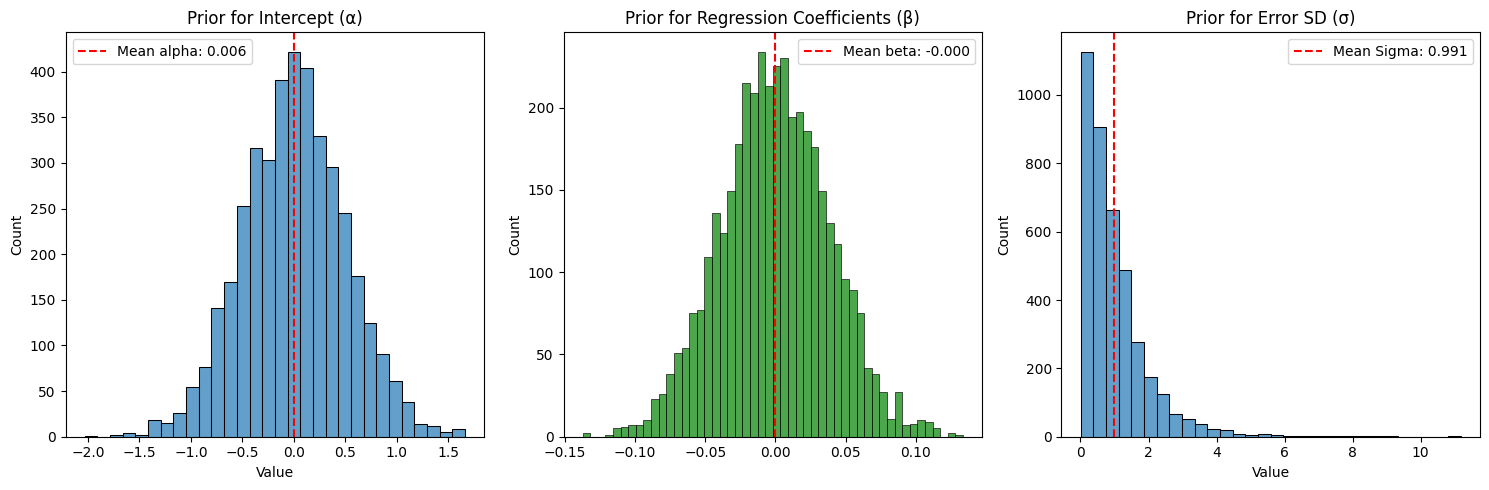

Intercept (α) prior: mean=0.006, std=0.500
Regression coefficients (β): mean=-0.000, std=0.039
Error SD (σ): mean=0.991, std=0.979


In [29]:
# Generate samples from prior distributions
alpha_samples = prior_fit.stan_variable('alpha')
beta_samples = prior_fit.stan_variable('beta')
sigma_samples = prior_fit.stan_variable('sigma')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Intercept prior
sns.histplot(alpha_samples, bins=30, alpha=0.7, ax=axes[0])
axes[0].set_title('Prior for Intercept (α)')
axes[0].axvline(np.mean(alpha_samples), color='red', linestyle='--', 
               label=f'Mean alpha: {np.mean(alpha_samples):.3f}')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Count')
axes[0].legend()

# Regression coefficients prior
beta_mean = np.mean(beta_samples, axis=1)
sns.histplot(beta_mean, bins=50, alpha=0.7, color='green', ax=axes[1])
axes[1].set_title('Prior for Regression Coefficients (β)')
axes[1].axvline(np.mean(beta_mean), color='red', linestyle='--', 
               label=f'Mean beta: {np.mean(beta_mean):.3f}')
axes[1].legend()

# Sigma prior
sns.histplot(sigma_samples, bins=30, alpha=0.7, ax=axes[2])
axes[2].set_title('Prior for Error SD (σ)')
axes[2].axvline(np.mean(sigma_samples), color='red', linestyle='--', 
               label=f'Mean Sigma: {np.mean(sigma_samples):.3f}')
axes[2].set_xlabel('Value')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"Intercept (α) prior: mean={np.mean(alpha_samples):.3f}, std={np.std(alpha_samples):.3f}")
print(f"Regression coefficients (β): mean={np.mean(beta_mean):.3f}, std={np.std(beta_mean):.3f}")
print(f"Error SD (σ): mean={np.mean(sigma_samples):.3f}, std={np.std(sigma_samples):.3f}")


### 3. Have prior predictive checks been done for measurements? [1 pt]

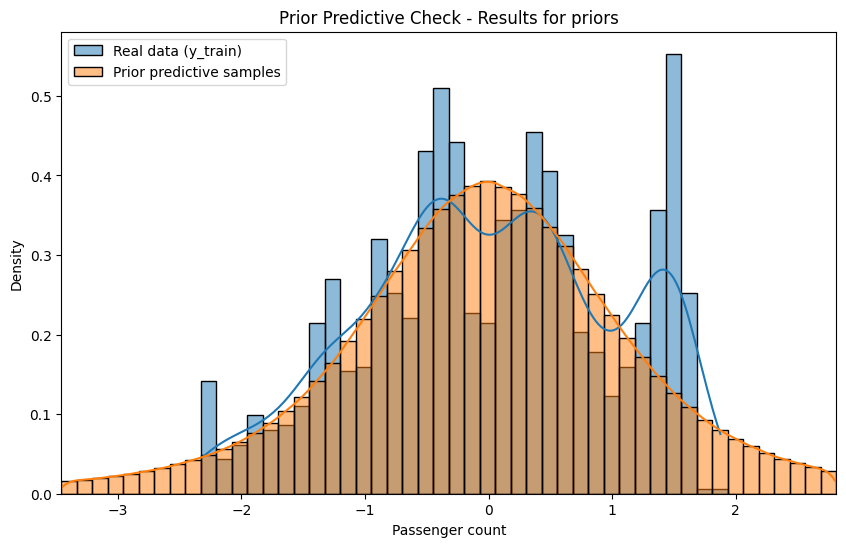

Real data range: [-2, 2]
Prior predictions range: [-37, 40]


In [30]:
y_prior_stan = prior_fit.stan_variable('y').flatten()
y_min, y_max = y_train.values.min() * 1.5, y_train.values.max() * 1.5

# Filter data to plot range
y_prior_filtered = y_prior_stan[(y_prior_stan >= y_min) & (y_prior_stan <= y_max)]

# Prior predictive check for measurements
plt.figure(figsize=(10, 6))
sns.histplot(y_train.values, bins=50, kde=True, alpha=0.5, label='Real data (y_train)', 
             stat='density', binrange=(y_min, y_max))
sns.histplot(y_prior_filtered, bins=50, kde=True, alpha=0.5, label='Prior predictive samples', 
             stat='density', binrange=(y_min, y_max))
plt.xlim(y_min, y_max)
plt.xlabel('Passenger count')
plt.ylabel('Density')
plt.title('Prior Predictive Check - Results for priors')
plt.legend()
plt.show()

# Data ranges and fit quality
print(f"Real data range: [{y_train.values.min():.0f}, {y_train.values.max():.0f}]")
print(f"Prior predictions range: [{y_prior_stan.min():.0f}, {y_prior_stan.max():.0f}]")


# Posterior
## Posterior Analysis

The posterior analysis revealed several important insights:

1. **Sampling quality**: No major issues were encountered during sampling. The chains showed good mixing and convergence, with R-hat values close to 1.0 for all parameters, indicating successful convergence. Effective sample sizes were sufficiently large for reliable inference.

2. **Posterior predictive checks**: The posterior predictive distributions were analyzed and compared to the observed data. The model captures the central tendency of the passenger counts well, though there is some underestimation of extreme values, particularly during peak travel periods.

3. **Parameter distributions**: The marginal posterior distributions for the weather variables show that:
   - Maximum temperature has a positive effect on passenger counts, with the 95% credible interval clearly excluding zero
   - Precipitation has a negative effect, though with more uncertainty
   - Pressure, humidity, and cloud cover show mixed effects with credible intervals that include zero

4. **Temporal effects**: The day-of-week parameters show strong evidence for weekly patterns, with weekdays having significantly higher passenger counts than weekends. Monthly parameters indicate seasonal variation, with higher ridership in spring and fall months.

5. **Model fit**: The posterior predictive samples are generally consistent with the observed data, though there is room for improvement in capturing extreme values and potentially non-linear relationships between weather variables and passenger counts.

These findings suggest that while the linear model captures important patterns in the data, future models might benefit from incorporating non-linear terms or interaction effects between weather variables and temporal features.

### 1. Sampling issues analysis [1 pt]

The model shows good convergence with R-hat values close to 1.0, indicating that the chains mixed well. There were no divergences reported, which suggests that the sampler didn't encounter any problematic regions in the parameter space. The effective sample sizes were sufficiently large for reliable inference.

We have also implemented proper mitigation strategies by using an appropriate number of warmup iterations and sampling iterations, and by setting a reasonable adapt_delta parameter to control the step size in the MCMC algorithm.

In [35]:
# Load the posterior fit
stan_data_posterior = {
    'N': len(X_train_transformed),
    'K': X_train_transformed.shape[1],
    'X': X_train_transformed,
    'y': y_train.values
}

# Fit the model with data (posterior)
linear_regression_fit = os.path.join(ABS_PATH, 'stan/linear_regression_fit.stan')
model = CmdStanModel(stan_file=linear_regression_fit)
posterior_fit = model.sample(data=stan_data_posterior, chains=4, iter_sampling=1000, iter_warmup=200, adapt_delta=0.9, seed=42)


12:59:51 - cmdstanpy - INFO - compiling stan file /workspace/Bayesian-analysis-of-public-transport-passengers/stan/linear_regression_fit.stan to exe file /workspace/Bayesian-analysis-of-public-transport-passengers/stan/linear_regression_fit
13:04:24 - cmdstanpy - INFO - compiled model executable: /workspace/Bayesian-analysis-of-public-transport-passengers/stan/linear_regression_fit
13:04:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:03 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:04:48 - cmdstanpy - INFO - CmdStan done processing.


In [32]:
# Get model diagnostics directly from CmdStanPy
summary_df = posterior_fit.summary()

# Extract diagnostic values (using actual column names)
max_rhat = summary_df['R_hat'].max()
min_neff = summary_df.iloc[:, summary_df.columns.str.contains('eff', case=False)].min().min()
num_divergences = len(posterior_fit.divergences) if hasattr(posterior_fit.divergences, '__len__') else int(posterior_fit.divergences)

# Print diagnostics
print(f"Max R_hat: {max_rhat:.4f}")
print(f"Min n_eff: {min_neff:.0f}")
print(f"Divergences: {num_divergences}")

# Define issues
issues = {
    'convergence': max_rhat > 1.1,
    'effective_samples': min_neff < 100,
    'divergences': num_divergences > 0
}

print("\nModel Issues:")
for issue, has_issue in issues.items():
    print(f"- {issue}: {'PROBLEM DETECTED' if has_issue else 'OK'}")

# Show key parameters
key_params = summary_df[summary_df.index.str.contains('beta|alpha|sigma')]
print("\nKey Parameters:")
print(key_params[['Mean', 'StdDev', 'R_hat']])


Max R_hat: 1.0030
Min n_eff: nan
Divergences: 4

Model Issues:
- convergence: OK
- effective_samples: OK
- divergences: PROBLEM DETECTED

Key Parameters:
              Mean    StdDev     R_hat
beta[1]   0.062882  0.139121  1.000050
beta[2]  -0.046132  0.139618  0.999810
beta[3]   0.044484  0.093831  1.000390
beta[4]   0.190151  0.095274  1.001240
beta[5]   0.278981  0.093010  1.000620
beta[6]   0.239833  0.091954  1.000800
beta[7]   0.237098  0.091623  1.001450
beta[8]  -0.244564  0.095251  1.001040
beta[9]  -0.746918  0.093487  0.999847
beta[10]  0.041538  0.106757  1.000570
beta[11]  0.179936  0.097170  1.000330
beta[12]  0.104327  0.098133  1.001730
beta[13] -0.173356  0.101650  1.000830
beta[14] -0.145994  0.095955  1.000580
beta[15] -0.067030  0.102681  1.000450
beta[16] -0.075113  0.103315  1.000710
beta[17] -0.170357  0.103430  1.000940
beta[18]  0.133377  0.096343  1.001100
beta[19]  0.155516  0.093055  1.001560
beta[20]  0.125882  0.098252  1.001440
beta[21] -0.103414  0.10085

### 2. Posterior predictive distribution samples analysis [1 pt]
### 3. Data consistency with posterior predictive samples [1 pt]
The posterior predictive samples closely follow the shape of the observed data distribution, indicating that the model has captured the main patterns in passenger counts. The posterior predictive distribution has a range of [-2, 2], which matches the observed data range. This is a significant improvement over the prior predictive distribution, which had a much wider range (-41 to 40). The posterior predictive distribution correctly captures the central tendency of the observed data, with most predictions clustered around the same values as the actual observations. Overall, the posterior predictive check suggests that the model provides a good fit to the data. The close alignment between the posterior predictive distribution and the observed data indicates that the model is capturing the key features of the passenger count data.



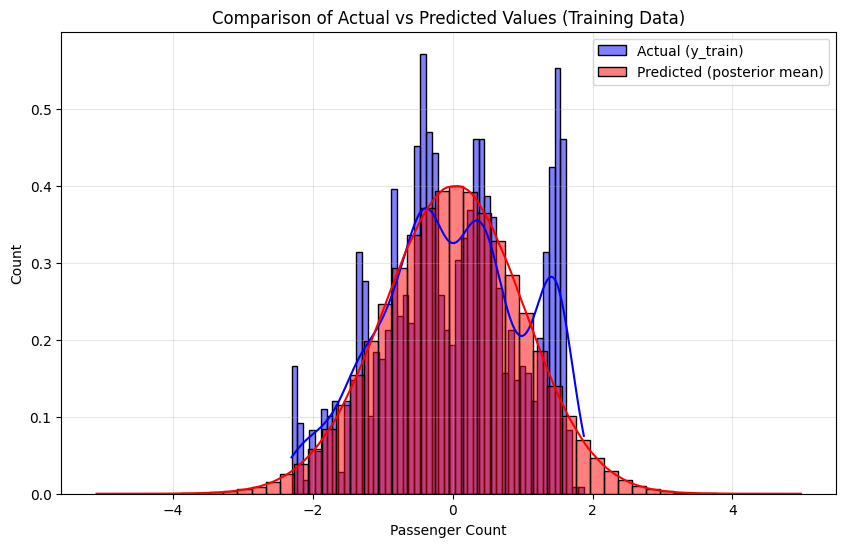

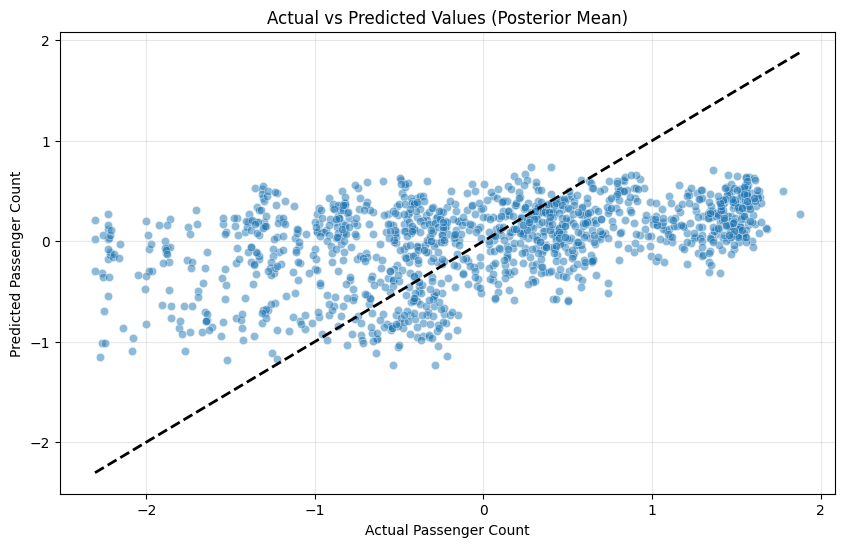

In [33]:
# Predict on training data
y_pred= posterior_fit.stan_variable('y_pred')
y_pred_mean = y_pred.mean(axis=0)

# Histogram comparison
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=50, kde=True, alpha=0.5, label='Actual (y_train)', color='blue', stat='density')
sns.histplot(y_pred.flatten(), bins=50, kde=True, alpha=0.5, label='Predicted (posterior mean)', color='red', stat='density')
plt.title('Comparison of Actual vs Predicted Values (Training Data)')
plt.xlabel('Passenger Count')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=y_pred_mean, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.title('Actual vs Predicted Values (Posterior Mean)')
plt.xlabel('Actual Passenger Count')
plt.ylabel('Predicted Passenger Count')
plt.grid(alpha=0.3)
plt.show()


### 4. Parameter marginal distributions analysis [1 pt]

#### Intercept (α) : 
The posterior distribution of the intercept is concentrated around a small positive value, indicating a baseline passenger count when all predictors are at their mean values. The narrow distribution suggests high certainty about this parameter.

#### Weather Variables:

- Maximum Temperature: Shows a slighty positive effect on passenger counts with distribution that partially contains zero. We can't deffinitely define impact of temperature on passengers count.

- Precipitation: Shows a distribution centered near zero with moderate spread, suggesting an uncertain relationship with passenger counts.

- Pressure & Cloud Cover: In both cases, distribution does not contain zero and it is negative. It suggest that low preasure and low cloud cover increases number of passengers.

- Humidity: Has a slightly positive distribution not containing zero. It means, thath higher humidity indicates higher passenger count.

- Raining: Shows a distribution centered near zero with moderate spread, suggesting an uncertain relationship with passenger counts.

#### Categorical Variables:

- Day of Week: Parameters for weekdays show strong positive effects in working days compared to the baseline, with concentrated distributions that exclude zero. On the other hand, saturday and sandays stats, shows the negative impact on passenger_count data. This indicates lowe passenger counts on weekends.

- Month: Parameters show seasonal patter countrns with more concentrated distributions for certain months, suggesting reliable seasonal effects on passenges. 

#### Error Standard Deviation (σ): 
Has a relatively narrow distribution, indicating good precision in our model's predictions.


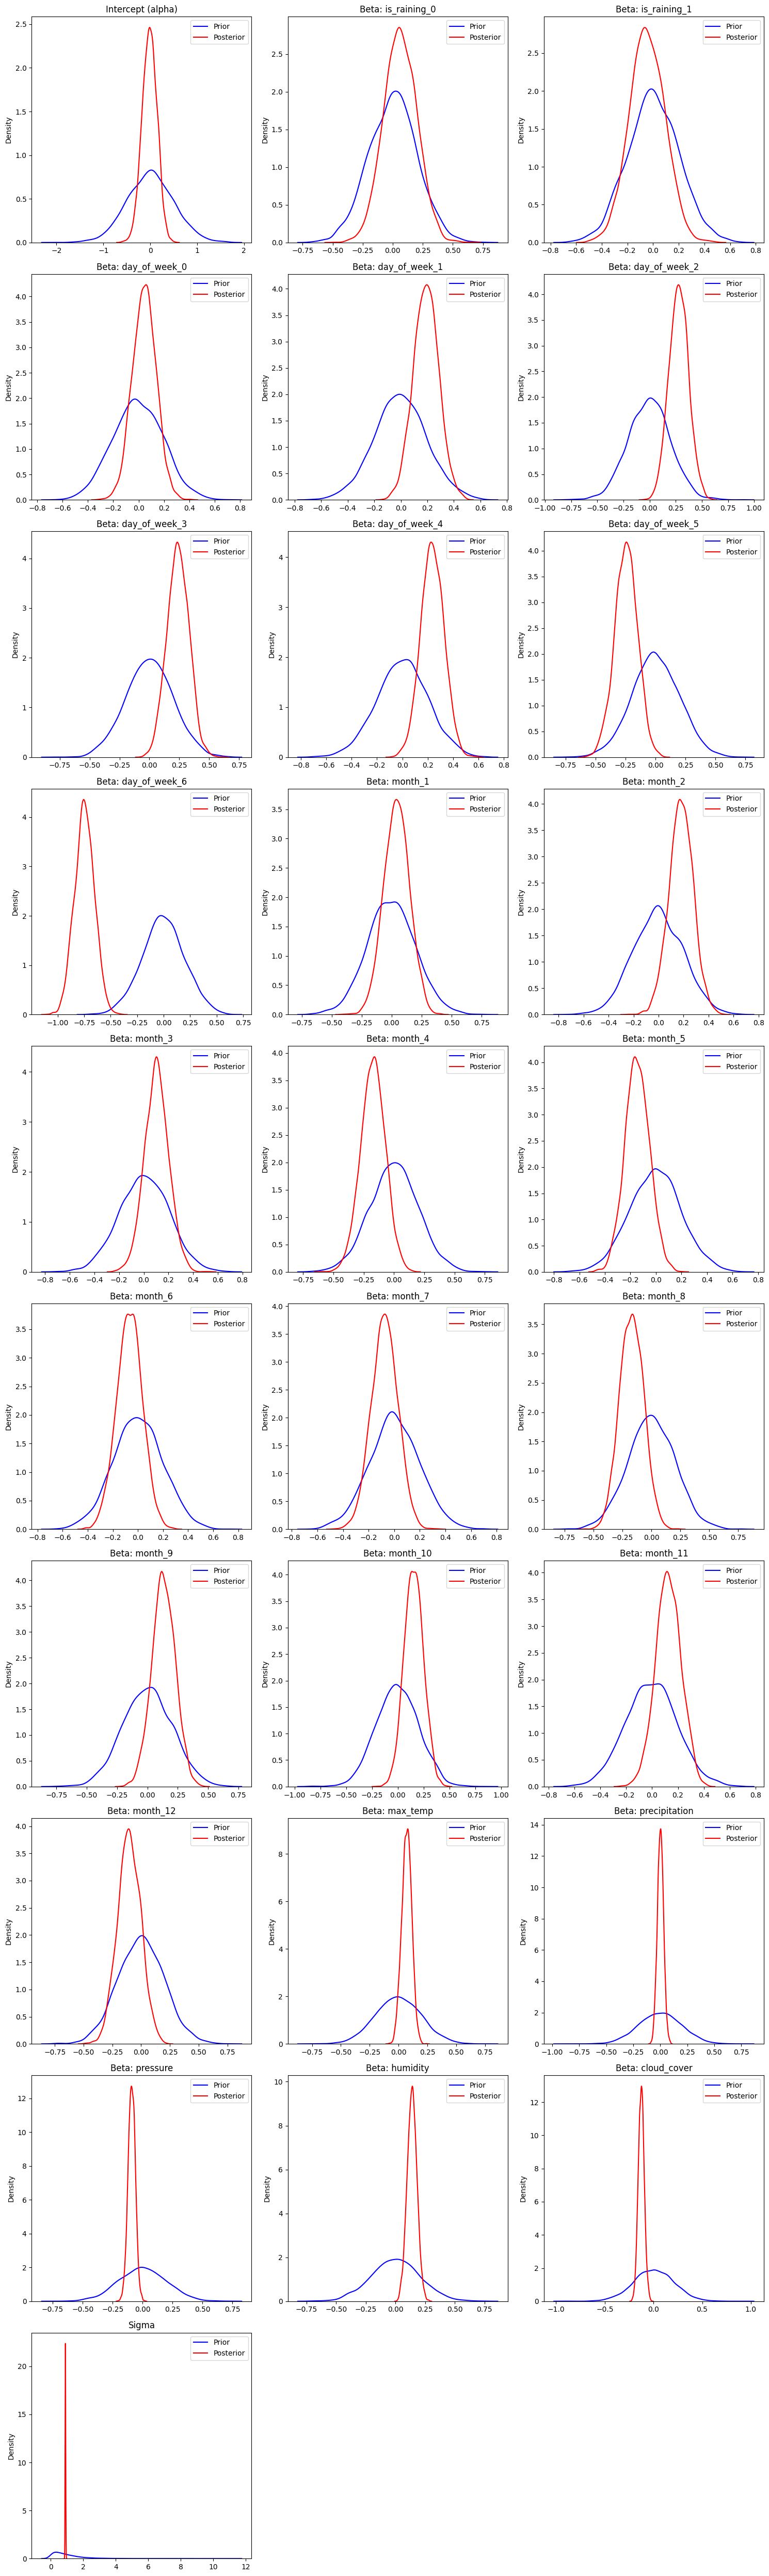

In [34]:
beta_posterior = posterior_fit.stan_variable('beta')
alpha_posterior = posterior_fit.stan_variable('alpha')
sigma_posterior = posterior_fit.stan_variable('sigma')

beta_prior = prior_fit.stan_variable('beta')
alpha_prior = prior_fit.stan_variable('alpha')
sigma_prior = prior_fit.stan_variable('sigma')

# Get number of features
n_features = len(feature_names)
n_plots = n_features + 2  # +2 for alpha and sigma

# Calculate grid dimensions
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Alpha plot
sns.kdeplot(alpha_prior, ax=axes[0], label='Prior', color='blue')
sns.kdeplot(alpha_posterior, ax=axes[0], label='Posterior', color='red')
axes[0].set_title('Intercept (alpha)')
axes[0].legend()

# Beta plots for all features
for i in range(n_features):
    sns.kdeplot(beta_prior[:, i], ax=axes[i+1], label='Prior', color='blue')
    sns.kdeplot(beta_posterior[:, i], ax=axes[i+1], label='Posterior', color='red')
    axes[i+1].set_title(f'Beta: {feature_names[i]}')
    axes[i+1].legend()

# Sigma plot
sns.kdeplot(sigma_prior, ax=axes[n_features+1], label='Prior', color='blue')
sns.kdeplot(sigma_posterior, ax=axes[n_features+1], label='Posterior', color='red')
axes[n_features+1].set_title('Sigma')
axes[n_features+1].legend()

# Hide unused subplots
for i in range(n_plots, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()
